In [ ]:
!pip install casadi scipy tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 7.5 MB/s eta 0:00:00


In [ ]:
import casadi as ca
import numpy as np
from scipy.linalg import svd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

## Model

In [ ]:
# === Model configuration ===
# System dimensions and simulation horizon
nx = 2          # Number of states
ny = 1          # Number of outputs
nth = 6         # Number of parameters
Tf = 5          # Final time [h]
Nt = 10         # Number of time points
t_eval = np.linspace(0, Tf, Nt)

In [ ]:
# Symbolic variables for states and parameters
x = ca.MX.sym("x", nx)
theta = ca.MX.sym("theta", nth)

# === Model definition ===
# Dynamical system for microbial growth and substrate consumption
mu, Ks, Y, Kd = theta[0], theta[1], theta[2], theta[3]
xdot = ca.vertcat(
    (mu * x[1] * x[0]) / (Ks + x[1]) - Kd * x[0],         # Biomass equation
    -(mu * x[1] * x[0]) / ((Ks + x[1]) * Y)               # Substrate equation
)

# Initial conditions as part of parameter vector
x0 = ca.vertcat(theta[4], theta[5])

#Nominal parameters
theta_nom = np.array([0.5, 2.0, 0.6, 0.01, 2.0, 1.0])

##Extended System

In [ ]:
# === Symbolic derivatives for extended system ===
# These Jacobians define the structure of the sensitivity dynamics

dfdx = ca.jacobian(xdot, x)        # ∂f/∂x → state Jacobian
dfdth = ca.jacobian(xdot, theta)   # ∂f/∂θ → parameter Jacobian
dx0dth = ca.jacobian(x0, theta)    # ∂x₀/∂θ → initial sensitivity matrix

# === CasADi function wrappers ===
# These functions allow efficient numerical evaluation of the model and its derivatives

f = ca.Function("f", [x, theta], [xdot])                 # System dynamics
dfdx_fun = ca.Function("dfdx", [x, theta], [dfdx])       # Jacobian ∂f/∂x
dfdth_fun = ca.Function("dfdth", [x, theta], [dfdth])    # Jacobian ∂f/∂θ
x0_fun = ca.Function("x0", [theta], [x0])                # Initial condition vector
dx0dth_fun = ca.Function("dx0dth", [theta], [dx0dth])    # ∂x₀/∂θ sensitivity matrix

# === Extended system: sensitivity ODEs ===
# Implements d(xθ)/dt = (∂f/∂x)·xθ + ∂f/∂θ
# Solves both the original system and the sensitivity dynamics

def meta_rhs(t, x_ext, theta_val):
    x = x_ext[:nx]
    dx_dth = x_ext[nx:].reshape((nx, nth))
    A = np.array(dfdx_fun(x, theta_val))        # ∂f/∂x evaluated at current state
    B = np.array(dfdth_fun(x, theta_val))       # ∂f/∂θ evaluated at current state
    dx = np.array(f(x, theta_val)).flatten()    # dx/dt
    d_dx_dth = A @ dx_dth + B                   # d(∂x/∂θ)/dt
    return np.concatenate([dx, d_dx_dth.flatten()])

# === Forward integration of state and sensitivities ===
# Solves the extended system using initial state and initial sensitivities

def simulate_once(theta_val):
    x0_val = np.array(x0_fun(theta_val)).flatten()                         # Initial state x₀(θ)
    dx0_val = np.array(dx0dth_fun(theta_val)).reshape((nx, nth))          # Initial ∂x₀/∂θ
    x0_ext = np.concatenate([x0_val, dx0_val.flatten()])                  # Extended initial condition
    sol = solve_ivp(lambda t, x: meta_rhs(t, x, theta_val),
                    t_span=(0, Tf), y0=x0_ext, t_eval=t_eval,
                    method="LSODA", rtol=1e-12, atol=1e-12)
    x_out = sol.y[:nx, :].T
    dx_dth_out = sol.y[nx:, :].T.reshape(Nt, nx, nth)
    return x_out, dx_dth_out

# === Sensitivity matrix computation (output) ===
# Implements: yθ = (∂h/∂x)·xθ + ∂h/∂θ
# In this model, h(x) = x₁(t), so ∂h/∂x = [1, 0] and ∂h/∂θ = 0

def compute_dydth(x_out, dx_dth_out, theta_val):

    # OSM: Output Sensitivity Matrix → dydth[i, j] = ∂y(t_i)/∂θ_j
    dydth = np.zeros((Nt * ny, nth))

    # ROSM: Relative Output Sensitivity Matrix → dydth_rel[i, j] = (∂y/∂θ)(θ_j / y(t))
    dydth_rel = np.zeros_like(dydth)

    # Store output values for optional plotting or normalization
    y_out = np.zeros((Nt, ny))

    for i in range(Nt):
        x_i = x_out[i]
        dx_i = dx_dth_out[i]
        y_i = x_i[0]  # Output y(t) = x₁(t) = biomass
        y_out[i] = y_i
        dydth_i = dx_i[0, :]  # Sensitivity of output with respect to parameters: ∂x₁/∂θ

        # Fill OSM row
        dydth[i] = dydth_i

        # Fill ROSM row (avoid division by zero)
        if y_i != 0:
            dydth_rel[i] = dydth_i * theta_val / y_i
        else:
            dydth_rel[i] = dydth_i * theta_val / np.mean(y_out[:, 0])
            # Use average output to avoid division by zero in relative sensitivity

    return dydth, dydth_rel, y_out

NameError: name 'ca' is not defined

##SVD

In [ ]:
# === SVD ===
x_out, dx_dth_out = simulate_once(theta_nom)
dydth, dydth_rel, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)
U, S, Vh = svd(dydth_rel, full_matrices=False)

##Plot

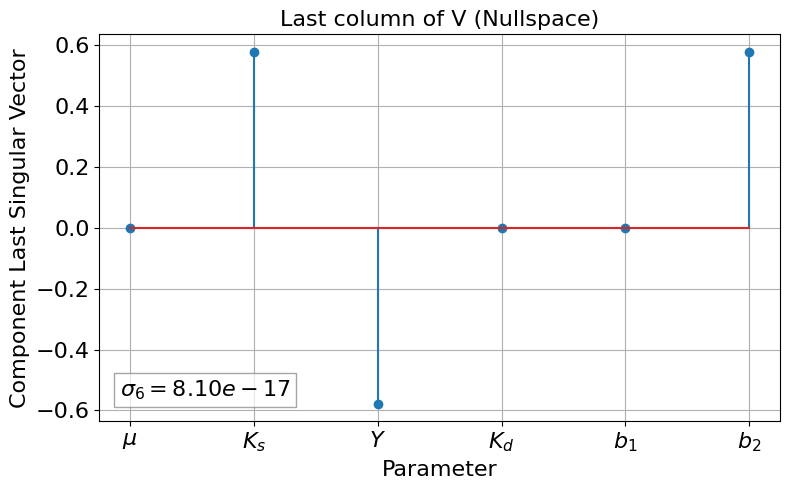

In [ ]:
# === Plot: last right singular vector (nullspace direction) ===
param_names = [r'$\mu$', r'$K_s$', r'$Y$', r'$K_d$', r'$b_1$', r'$b_2$']

plt.figure(figsize=(8, 5))
plt.stem(Vh[-1])
plt.title("Last column of V (Nullspace)", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel("Component Last Singular Vector", fontsize=16)
plt.xticks(np.arange(nth), param_names, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)

# Annotate last singular value σ₆ in the lower-left corner
plt.text(
    0.03, 0.05,
    r'$\sigma_{%d} = %.2e$' % (nth, S[-1]),
    fontsize=16,
    transform=plt.gca().transAxes,
    ha='left', va='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.tight_layout()
plt.show()

##Monte Carlo

In [ ]:
# === Monte Carlo sensitivity analysis ===
# Sample parameter vectors around the nominal values
NExp = 10
theta_nom = np.array([0.5, 2.0, 0.6, 0.01, 2.0, 1.0])
theta_low = 0.5 * theta_nom
theta_high = 1.5 * theta_nom

In [ ]:
THETA = np.random.uniform(theta_low, theta_high, size=(NExp, nth))
THETA[0] = theta_nom  # Ensure nominal parameters are included

# Start CPU time measurement
start_time = time.perf_counter()

# Storage arrays for singular values and nullspace vectors
SingularValues = np.zeros((NExp, nth))
V_last_cols = np.zeros((nth, NExp))

# Loop over each sampled parameter set
for k in range(NExp):
    theta_k = THETA[k]
    x_out, dx_dth_out = simulate_once(theta_k)
    dydth, dydth_rel, _ = compute_dydth(x_out, dx_dth_out, theta_nom)
    U, S, Vh = svd(dydth_rel, full_matrices=False)
    SingularValues[k] = S
    V_last_cols[:, k] = (Vh[-1])

# End CPU time measurement
elapsed_time = time.perf_counter() - start_time
avg_time_per_exp = elapsed_time / NExp

print(f"Monte Carlo analysis completed in {elapsed_time:.2f} seconds.")
print(f"Average time per experiment: {avg_time_per_exp:.2f} seconds.")

Monte Carlo analysis completed in 0.99 seconds.
Average time per experiment: 0.10 seconds.


##Plot

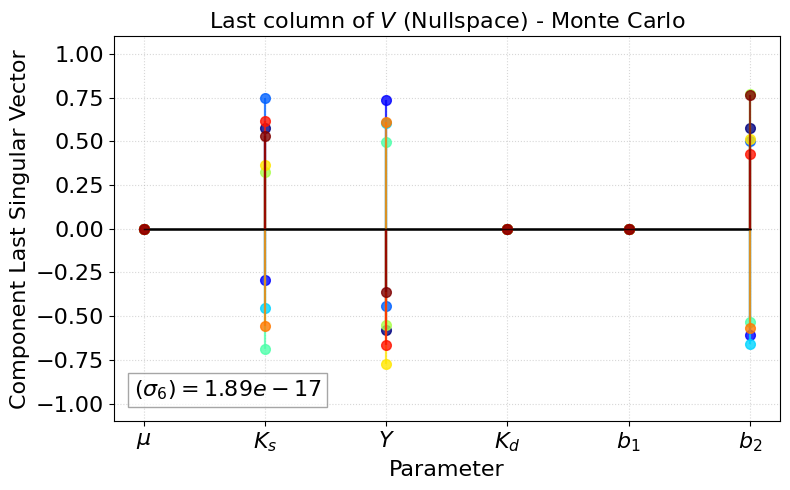

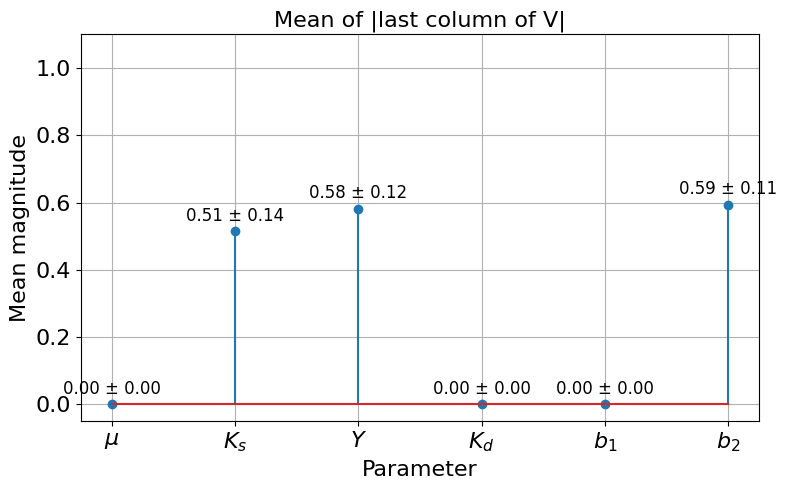

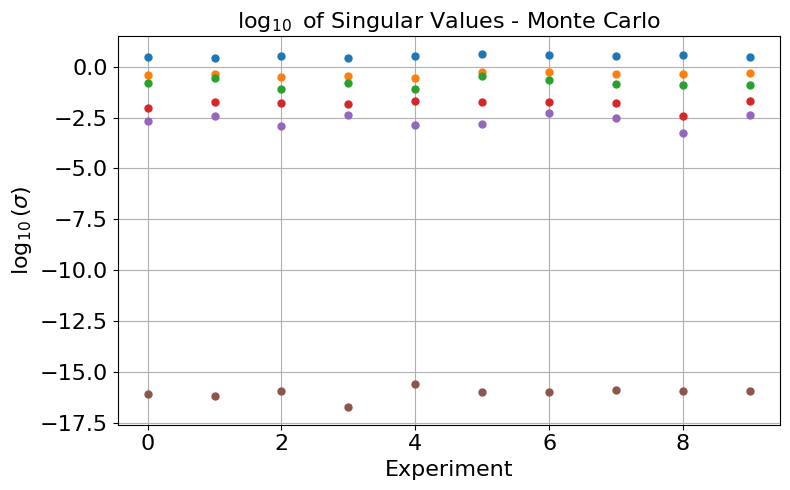

In [ ]:
# Compute mean and standard deviation of nullspace components
mean_v = np.mean(np.abs(V_last_cols), axis=1)
std_v = np.std(np.abs(V_last_cols), axis=1)
min_sigma = np.min(SingularValues[:, -1])
max_sigma = np.max(SingularValues[:, 0])

# === Plot: Last column of V for each experiment ===
param_names = [r'$\mu$', r'$K_s$', r'$Y$', r'$K_d$', r'$b_1$', r'$b_2$']
x_vals = np.arange(nth)
colors = plt.cm.jet(np.linspace(0, 1, NExp))

plt.figure(figsize=(8, 5))
for k in range(NExp):
    v_last = V_last_cols[:, k]
    markerline, stemlines, baseline = plt.stem(
        x_vals, v_last,
        linefmt='-', markerfmt='o', basefmt='k-',
        label=f'Exp {k+1}'
    )
    plt.setp(markerline, color=colors[k], markersize=7, alpha=0.8)
    plt.setp(stemlines, color=colors[k], linewidth=1.6, alpha=0.8)
    plt.setp(baseline, color='k', linewidth=1.0, alpha=0.7)

plt.xticks(x_vals, param_names, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.title(r"Last column of $V$ (Nullspace) - Monte Carlo", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel(r"Component Last Singular Vector", fontsize=16)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=':', alpha=0.5)

plt.text(
    0.03, 0.05,
    r'$(\sigma_{\mathrm{6}})=%.2e$' % min_sigma,
    fontsize=16,
    transform=plt.gca().transAxes,
    ha='left', va='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.tight_layout()
plt.show()

# === Plot: Mean of |last column of V| ===
plt.figure(figsize=(8, 5))
plt.stem(mean_v)
plt.xticks(x_vals, param_names, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
for i in range(nth):
    plt.text(i, mean_v[i] + 0.02, f"{mean_v[i]:.2f} ± {std_v[i]:.2f}", ha='center', va='bottom', fontsize=12)

plt.title("Mean of |last column of V|", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel("Mean magnitude", fontsize=16)
plt.ylim(-0.05, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: log10 of singular values across experiments ===
plt.figure(figsize=(8, 5))
plt.plot(np.log10(SingularValues), '.', markersize=10)
plt.title(r"$\log_{10}$ of Singular Values - Monte Carlo", fontsize=16)
plt.xlabel("Experiment", fontsize=16)
plt.ylabel(r"$\log_{10}(\sigma)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
